Cell 1 — Load data, align, make target, build rolling splits

In [26]:
import pandas as pd
import numpy as np
from pathlib import Path

In [27]:
# --- Load datasets ---
unw = pd.read_csv("Data/10_day_run/merged_dataset.csv")
wtd = pd.read_csv("Data/10_day_run/merged_dataset_weighted.csv")

In [28]:
for df in (unw, wtd):
    df['Week'] = pd.to_datetime(df['Week'], errors='coerce')
    df.sort_values('Week', inplace=True)
    df.reset_index(drop=True, inplace=True)

In [29]:
# Align rows by Week to ensure identical OOS windows for both feature sets
df_all = pd.merge(
    wtd.add_prefix("w_"),
    unw.add_prefix("u_"),
    left_on="w_Week",
    right_on="u_Week",
    how="inner"
)

In [30]:
# Carry Week, Close, Volume (prefer weighted side if present)
df_all['Week']   = df_all['w_Week']
df_all['Close']  = df_all['w_Close']   if 'w_Close'   in df_all.columns else df_all['u_Close']
df_all['Volume'] = df_all['w_Volume']  if 'w_Volume'  in df_all.columns else df_all['u_Volume']

In [31]:
# --- Target from Close with ±1% rule (Up=1, Down=-1, Neutral=0) ---
df_all = df_all.sort_values('Week').reset_index(drop=True)
df_all['Return_protocol'] = df_all['Close'].pct_change()

In [32]:
delta = 0.01
def to_label(r):
    if pd.isna(r): return np.nan
    if r >  delta: return  1
    if r < -delta: return -1
    return 0

df_all['Target_protocol'] = df_all['Return_protocol'].apply(to_label)
df_all = df_all.dropna(subset=['Target_protocol']).reset_index(drop=True)
df_all['Target_protocol'] = df_all['Target_protocol'].astype(int)

In [33]:
# --- Rolling-origin expanding-window splits ---
N = len(df_all)
initial_train_weeks = max(52, int(0.5 * N))   # at least 1 year, ~50% of history
test_weeks         = max(16, int(0.1 * N))    # ~10% per OOS block

splits = []
train_end = initial_train_weeks - 1
sid = 1
while True:
    te_start = train_end + 1
    te_end   = te_start + test_weeks - 1
    if te_start >= N: break
    if te_end >= N: te_end = N - 1
    splits.append((sid, 0, int(train_end), int(te_start), int(te_end)))
    sid += 1
    if te_end >= N - 1: break
    train_end = te_end

In [34]:
print(f"Rows: {N}, splits: {len(splits)}, period: {df_all['Week'].min().date()} — {df_all['Week'].max().date()}")

Rows: 212, splits: 6, period: 2007-02-11 — 2013-12-01


“We use an expanding-window protocol with ~50% initial training and ~10% non-overlapping OOS blocks, aligned across datasets by calendar week.”

## Cell 2 — Build feature sets (with lags) for both datasets

In [35]:
# Unweighted features (prefix u_): news + filings + counts + volume
u_exclude = {'Week', 'Close', 'Return', 'Target', 'Year', 'Adj Close', 'mean_news_sentiment', 'std_news_sentiment', 'count_10k', '10q_mda_sent',
       '10q_risk_sent', 'count_10q', 'log_return'}
u_candidates = ["u_" + c for c in unw.columns if c not in u_exclude]
# Weighted features (prefix w_): same families, but weighted filing scores + counts + volume
w_exclude = {'Week', 'Close', 'Return', 'Target', 'Year', 'Adj Close', 'mean_news_sentiment', 'std_news_sentiment', '10q_mda_sent', '10q_risk_sent',
       '10q_mda_sent_weighted', '10q_risk_sent_weighted'}
w_candidates = ["w_" + c for c in wtd.columns if c not in w_exclude]

In [36]:
u_features = [c for c in u_candidates if c in df_all.columns]
w_features = [c for c in w_candidates if c in df_all.columns]

In [39]:
def add_lags(df, cols, lags=(1,2)):
    df = df.copy()
    for L in lags:
        for c in cols:
            df[f"{c}_lag{L}"] = df[c].shift(L)
    return df

df_feats = add_lags(add_lags(df_all.copy(), u_features), w_features)

In [40]:
def build_X(df, base_cols):
    cols = []
    for c in base_cols:
        cols.append(c)
        for L in (1,2):
            cl = f"{c}_lag{L}"
            if cl in df.columns:
                cols.append(cl)
    return df[cols].copy(), cols

In [41]:
Xu, u_cols = build_X(df_feats, u_features)
Xw, w_cols = build_X(df_feats, w_features)
y = df_feats['Target_protocol'].astype(int).copy()

print("Unweighted feature cols:", len(u_cols))
print("Weighted   feature cols:", len(w_cols))

Unweighted feature cols: 48
Weighted   feature cols: 54


“We include contemporaneous and lagged (1–2 weeks) features for news and filings sentiment, document counts, and volume.”

## Cell 3 — Train tuned, calibrated RF per split; save predictions/metrics

In [42]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import matthews_corrcoef, make_scorer, accuracy_score, f1_score
import numpy as np
import pandas as pd

In [43]:
labels_order = [-1, 0, 1]
def mcc_scorer(): return make_scorer(matthews_corrcoef)

In [44]:
def fit_calibrated_rf(X_tr, y_tr):
    # Light grid + time-series CV to avoid overfitting on small N
    tscv = TimeSeriesSplit(n_splits=3)
    rf = RandomForestClassifier(random_state=42)
    grid = {
        "n_estimators":     [300],
        "max_depth":        [3, 5, None],
        "min_samples_leaf": [2, 4, 8],
        "max_features":     ["sqrt", 0.5],
        "class_weight":     [None, "balanced"],
    }
    gs = GridSearchCV(rf, grid, scoring=mcc_scorer(), cv=tscv, n_jobs=-1, refit=True)
    gs.fit(X_tr, y_tr)
    best = gs.best_estimator_
    best_params = gs.best_params_
    # Probability calibration on training only (time-series CV)
    calib = CalibratedClassifierCV(best, method="isotonic", cv=TimeSeriesSplit(n_splits=3))
    calib.fit(X_tr, y_tr)
    return calib, best_params

In [45]:
def brier_multiclass(y_true, proba, classes):
    from sklearn.preprocessing import OneHotEncoder
    oh = OneHotEncoder(categories=[classes], sparse_output=False, handle_unknown='ignore')
    Y = oh.fit_transform(y_true.reshape(-1,1))
    return np.mean(np.sum((proba - Y)**2, axis=1))

In [46]:
def metric_tuple(y_true, y_pred, y_proba, classes):
    acc     = accuracy_score(y_true, y_pred)
    mcc     = matthews_corrcoef(y_true, y_pred)
    f1_w    = f1_score(y_true, y_pred, average='weighted', labels=classes, zero_division=0)
    f1_macro= f1_score(y_true, y_pred, average='macro',   labels=classes, zero_division=0)
    brier   = brier_multiclass(y_true, y_proba, classes)
    return acc, f1_w, f1_macro, mcc, brier

In [47]:
def run_experiment(label, X):
    results, preds_records, best_rows = [], [], []
    for sid, tr0, tr1, te0, te1 in splits:
        # Slice and drop lag-induced NaNs
        X_tr = X.iloc[tr0:tr1+1].copy(); y_tr = y.iloc[tr0:tr1+1].copy()
        X_te = X.iloc[te0:te1+1].copy(); y_te = y.iloc[te0:te1+1].copy()
        tr_mask = ~X_tr.isna().any(axis=1)
        te_mask = ~X_te.isna().any(axis=1)
        X_tr, y_tr = X_tr[tr_mask], y_tr[tr_mask]
        X_te, y_te = X_te[te_mask], y_te[te_mask]
        if len(X_tr) < 30 or len(X_te) < 5: 
            continue

        model, best_params = fit_calibrated_rf(X_tr, y_tr)

        proba = model.predict_proba(X_te)
        y_hat = np.array([labels_order[i] for i in proba.argmax(axis=1)])

        acc, f1w, f1m, mcc, brier = metric_tuple(y_te.values, y_hat, proba, labels_order)
        results.append({
            "dataset": label, "split_id": sid, "test_size": len(y_te),
            "Accuracy": acc, "Weighted F1": f1w, "Macro F1": f1m, "MCC": mcc, "Brier": brier
        })

        tmp = pd.DataFrame({
            "Week": df_feats.loc[te0:te1, 'Week'].values[te_mask.values],
            "split_id": sid,
            "y_true": y_te.values,
            "y_pred": y_hat
        })
        for j, c in enumerate(labels_order):
            tmp[f"p_{c}"] = proba[:, j]
        preds_records.append(tmp)

        best_row = {"dataset": label, "split_id": sid}; best_row.update(best_params); best_rows.append(best_row)

    return pd.DataFrame(results), (pd.concat(preds_records, ignore_index=True) if preds_records else pd.DataFrame()), pd.DataFrame(best_rows)


In [48]:
u_metrics, u_preds, u_best = run_experiment("unweighted", Xu)
w_metrics, w_preds, w_best = run_experiment("weighted", Xw)

In [39]:
# Save artefacts
u_preds.to_csv("Data/10_day_run/rf_unweighted_predictions.csv", index=False)
w_preds.to_csv("Data/10_day_run/rf_weighted_predictions.csv",  index=False)
u_metrics.to_csv("Data/10_day_run/rf_unweighted_per_split.csv", index=False)
w_metrics.to_csv("Data/10_day_run/rf_weighted_per_split.csv",  index=False)
u_best.to_csv("Data/10_day_run/rf_unweighted_best_params.csv", index=False)
w_best.to_csv("Data/10_day_run/rf_weighted_best_params.csv",  index=False)

In [49]:
u_metrics

,dataset,split_id,test_size,Accuracy,Weighted F1,Macro F1,MCC,Brier
0,unweighted,1,21,0.619048,0.487734,0.262626,0.081992,0.569523
1,unweighted,2,21,0.476190,0.428317,0.338681,0.179588,0.663052
2,unweighted,3,21,0.190476,0.106667,0.106667,-0.303185,0.739989
3,unweighted,4,21,0.238095,0.157699,0.168831,0.073193,0.726430
4,unweighted,5,21,0.190476,0.175794,0.169444,-0.224926,0.730188


In [50]:
w_metrics

,dataset,split_id,test_size,Accuracy,Weighted F1,Macro F1,MCC,Brier
0,weighted,1,21,0.619048,0.543651,0.361111,0.132110,0.616172
1,weighted,2,21,0.285714,0.148148,0.148148,-0.166061,0.662194
2,weighted,3,21,0.238095,0.133333,0.133333,-0.221832,0.729468
3,weighted,4,21,0.285714,0.305470,0.218782,-0.050855,0.704809
4,weighted,5,21,0.285714,0.160000,0.160000,-0.121653,0.709423


In [23]:
u_best.head()

,dataset,split_id,class_weight,max_depth,max_features,min_samples_leaf,n_estimators
0,unweighted,1,None,NaN,0.5,2,300
1,unweighted,2,None,NaN,0.5,2,300
2,unweighted,3,balanced,5.0,0.5,2,300
3,unweighted,4,None,3.0,0.5,2,300
4,unweighted,5,None,3.0,sqrt,4,300


In [32]:
w_best.head()

,dataset,split_id,class_weight,max_depth,max_features,min_samples_leaf,n_estimators
0,weighted,1,balanced,NaN,sqrt,2,300
1,weighted,2,None,NaN,0.5,4,300
2,weighted,3,None,3.0,0.5,2,300
3,weighted,4,None,NaN,sqrt,2,300
4,weighted,5,None,NaN,0.5,2,300


## Cell 4 — Pooled metrics + CIs (block bootstrap) and significance vs Random-Walk

In [34]:
# ---- Load Random-Walk predictions from Day 1 ----
rw = pd.read_csv("Data/10_day_run/rw_predictions_all.csv")   # Week, split_id, y_true, y_pred

labels_order = [-1,0,1]

# Moving-block bootstrap CIs for multiclass metrics (uses model probabilities)
def mbb_indices(n, block_len=10, rng=None):
    if rng is None: rng = np.random.default_rng()
    k = int(np.ceil(n / block_len))
    starts = rng.integers(low=0, high=n, size=k)
    idx = []
    for s in starts:
        idx.extend([(s+i) % n for i in range(block_len)])
    return np.array(idx[:n], dtype=int)

In [35]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import OneHotEncoder

In [36]:
def brier_multiclass(y_true, proba, classes):
    oh = OneHotEncoder(categories=[classes], sparse_output=False, handle_unknown='ignore')
    Y = oh.fit_transform(y_true.reshape(-1,1))
    return np.mean(np.sum((proba - Y)**2, axis=1))

In [37]:
def metric_tuple(y_true, y_pred, proba=None, classes=labels_order):
    acc  = accuracy_score(y_true, y_pred)
    mcc  = matthews_corrcoef(y_true, y_pred)
    f1w  = f1_score(y_true, y_pred, average='weighted', labels=classes, zero_division=0)
    f1m  = f1_score(y_true, y_pred, average='macro',   labels=classes, zero_division=0)
    bri  = np.nan
    if proba is not None:
        bri = brier_multiclass(y_true, proba, classes)
    return acc, f1w, f1m, mcc, bri

In [38]:
def pooled_with_ci(preds_df, block_len=10, B=4000, seed=123):
    y_true = preds_df['y_true'].astype(int).to_numpy()
    y_pred = preds_df['y_pred'].astype(int).to_numpy()
    proba_cols = [c for c in preds_df.columns if c.startswith('p_')]
    proba = preds_df[proba_cols].to_numpy() if len(proba_cols)==3 else None
    rng = np.random.default_rng(seed)
    n = len(y_true)
    boot = []
    for _ in range(B):
        idx = mbb_indices(n, block_len=block_len, rng=rng)
        boot.append(metric_tuple(y_true[idx], y_pred[idx], None if proba is None else proba[idx]))
    boot = np.array(boot)
    pt = np.array(metric_tuple(y_true, y_pred, proba))
    lo = np.percentile(boot, 2.5, axis=0); hi = np.percentile(boot, 97.5, axis=0)
    out = pd.DataFrame({
        "Metric": ["Accuracy","Weighted F1","Macro F1","MCC","Brier"],
        "Point":  pt, "CI Lower (95%)": lo, "CI Upper (95%)": hi,
        "n_weeks": [n]*5
    })
    return out

In [40]:
u_pooled = pooled_with_ci(pd.read_csv("Data/10_day_run/rf_unweighted_predictions.csv"))
w_pooled = pooled_with_ci(pd.read_csv("Data/10_day_run/rf_weighted_predictions.csv"))

u_pooled.to_csv("Data/10_day_run/rf_unweighted_pooled_ci.csv", index=False)
w_pooled.to_csv("Data/10_day_run/rf_weighted_pooled_ci.csv",  index=False)

In [42]:
u_pooled

,Metric,Point,CI Lower (95%),CI Upper (95%),n_weeks
0,Accuracy,0.342857,0.238095,0.457143,105
1,Weighted F1,0.285047,0.184079,0.392251,105
2,Macro F1,0.274893,0.179007,0.363192,105
3,MCC,-0.021377,-0.174610,0.146517,105
4,Brier,0.685836,0.644065,0.724263,105


In [43]:
w_pooled

,Metric,Point,CI Lower (95%),CI Upper (95%),n_weeks
0,Accuracy,0.342857,0.247619,0.438095,105
1,Weighted F1,0.291120,0.191268,0.393864,105
2,Macro F1,0.261261,0.186389,0.327100,105
3,MCC,-0.040046,-0.161484,0.087896,105
4,Brier,0.684413,0.648522,0.720725,105


## Now the significance tests vs Random-Walk (paired on the same weeks):

In [44]:
# Align your model OOS with RW and run McNemar (hits) + Diebold–Mariano (0–1 loss)
def evaluate_model_vs_rw(model_preds_csv):
    model_df = pd.read_csv(model_preds_csv)
    merged = pd.merge(
        rw.rename(columns={'y_pred':'y_pred_rw'}),
        model_df[['Week','split_id','y_pred']],
        on=['Week','split_id'], how='inner'
    ).rename(columns={'y_pred':'y_pred_model'})
    y_true = merged['y_true'].astype(int).to_numpy()
    y_rw   = merged['y_pred_rw'].astype(int).to_numpy()
    y_m    = merged['y_pred_model'].astype(int).to_numpy()

    # McNemar
    hit_rw = (y_rw   == y_true).astype(int)
    hit_m  = (y_m    == y_true).astype(int)
    n01 = int(((hit_rw == 0) & (hit_m == 1)).sum())  # RW wrong, model right
    n10 = int(((hit_rw == 1) & (hit_m == 0)).sum())  # RW right, model wrong
    from math import fabs
    from scipy.stats import chi2, norm
    if (n01 + n10) == 0:
        mcnemar = {"n01": n01, "n10": n10, "chi2": 0.0, "p_value": 1.0}
    else:
        chi2_stat = (fabs(n01 - n10) - 1)**2 / (n01 + n10)
        mcnemar = {"n01": n01, "n10": n10, "chi2": chi2_stat, "p_value": 1 - chi2.cdf(chi2_stat, 1)}

    # DM test on 0–1 loss (h=1 → lag=0)
    loss_m  = (y_m  != y_true).astype(int)
    loss_rw = (y_rw != y_true).astype(int)
    d = loss_m - loss_rw
    T = len(d); d_bar = d.mean()
    var = d.var(ddof=0) / T
    dm_stat = d_bar / (np.sqrt(var) + 1e-12)
    p_dm = 2 * (1 - norm.cdf(abs(dm_stat)))
    dm = {"dm_stat": dm_stat, "p_value": p_dm, "mean_diff": d_bar, "T": T}

    return mcnemar, dm, len(merged)

In [45]:
mc_u, dm_u, n_u = evaluate_model_vs_rw("Data/10_day_run/rf_unweighted_predictions.csv")
mc_w, dm_w, n_w = evaluate_model_vs_rw("Data/10_day_run/rf_weighted_predictions.csv")

In [46]:
print("Unweighted vs RW — McNemar:", mc_u, " | DM:", dm_u, " | aligned weeks:", n_u)
print("Weighted   vs RW — McNemar:", mc_w, " | DM:", dm_w, " | aligned weeks:", n_w)

Unweighted vs RW — McNemar: {'n01': 19, 'n10': 22, 'chi2': 0.0975609756097561, 'p_value': np.float64(0.7547764265871045)}  | DM: {'dm_stat': np.float64(0.46917357023158157), 'p_value': np.float64(0.6389455754689068), 'mean_diff': np.float64(0.0379746835443038), 'T': 79}  | aligned weeks: 79
Weighted   vs RW — McNemar: {'n01': 16, 'n10': 21, 'chi2': 0.43243243243243246, 'p_value': np.float64(0.5107977981738965)}  | DM: {'dm_stat': np.float64(0.8255328496398758), 'p_value': np.float64(0.40906914081068146), 'mean_diff': np.float64(0.06329113924050633), 'T': 79}  | aligned weeks: 79


## Cell 5 — Reliability (calibration) curves

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
def reliability_points(y_true, proba, cls, classes=(-1,0,1), n_bins=10):
    p = proba[:, list(classes).index(cls)]
    y = (y_true == cls).astype(int)
    bins = np.linspace(0, 1, n_bins+1)
    mids = 0.5*(bins[:-1]+bins[1:])
    idx = np.digitize(p, bins)-1
    emp = []
    for b in range(n_bins):
        mask = idx == b
        emp.append(np.nan if mask.sum()==0 else y[mask].mean())
    return mids, np.array(emp)

In [49]:
def plot_reliability(title, preds_csv, out_png):
    dfp = pd.read_csv(preds_csv)
    y = dfp['y_true'].astype(int).to_numpy()
    P = dfp[['p_-1','p_0','p_1']].to_numpy()
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    for ax, cls in zip(axes, [-1,0,1]):
        mids, emp = reliability_points(y, P, cls)
        ax.plot([0,1],[0,1], linestyle='--')
        ax.plot(mids, emp, marker='o')
        ax.set_title(f"class {cls}")
        ax.set_xlabel("Predicted probability")
        ax.set_ylabel("Empirical frequency")
        ax.set_xlim(0,1); ax.set_ylim(0,1)
    fig.suptitle(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()

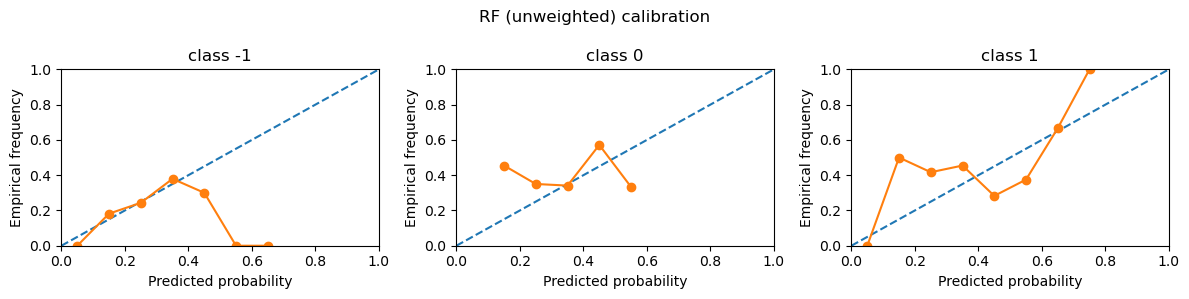

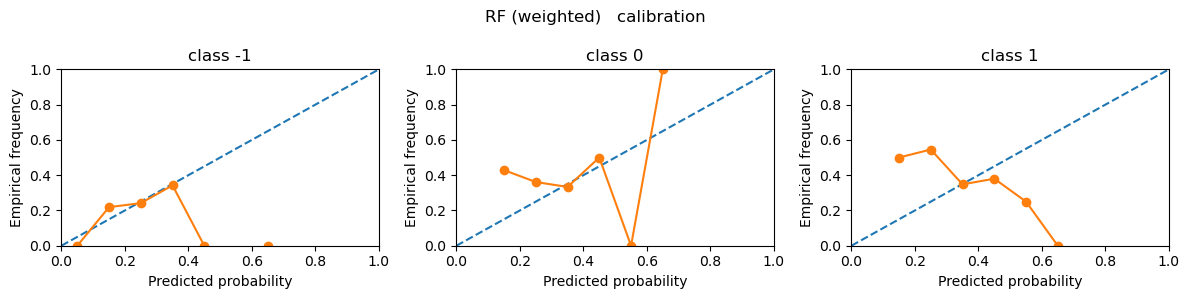

In [50]:
plot_reliability("RF (unweighted) calibration", "Data/10_day_run/rf_unweighted_predictions.csv", "Data/10_day_run/rf_unweighted_calibration.png")
plot_reliability("RF (weighted)   calibration", "Data/10_day_run/rf_weighted_predictions.csv",  "Data/10_day_run/rf_weighted_calibration.png")